In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from talib import abstract

from functools import partial

In [2]:
#Download Data from yahoo
stock='ACC'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

###### Download Data from yahoo hourly
#Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
stock='TCS'
exchange=['.NS','.BO']
startdate='2020-02-01'
hdfo = yf.download(stock+exchange[0],interval='1h',start=startdate)

#Download Data from yahoo weekly
#Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
stock='TCS'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
wdfo = yf.download(stock+exchange[0],start=startdate,interval='1wk')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
###### Copy df (daily), weekly df and hourly df from downloaded one.
wdf=wdfo.copy()
df=dfo.copy()
hdf=hdfo.copy()

In [4]:
def rwema(windows,df,field):
    
    for window in windows:
        alpha=1/window
        weights=list(reversed([(1-alpha)**n for n in range(window)]))
        ewma = partial(np.average, weights=weights)
        df['RWEMA_'+str(window)] = df[field].rolling(window).apply(ewma)
        df.replace(to_replace=np.nan,value=0,inplace=True)
        ##########TO check how much  moving up or down from given point 
        count = 0
        for index, row in df.iterrows():
            if row['RWEMA_'+str(window)] <  row[field]:
                count += 1
            else:
                count = 0
            df.loc[index, 'cum_above_0'] = count

        count = 0
        for index, row in df.iterrows():
            if row['RWEMA_'+str(window)] >  row[field]:
                count -= 1
            else:
                count = 0
            df.loc[index, 'cum_below_0'] = count

        df['RWEMA_'+str(window)+'_movement']=df['cum_above_0']+df['cum_below_0']
        df.drop('cum_above_0',axis=1,inplace=True)
        df.drop('cum_below_0',axis=1,inplace=True)
    return df

In [5]:
def madisparity(df,window,field):
    alpha=1/window
    weights=list(reversed([(1-alpha)**n for n in range(window)]))
    ewma = partial(np.average, weights=weights)
    # df[field+'_di']=(df[field]-df[field].rolling(ma).mean())/df[field].rolling(ma).mean()*100
    df[str(window)+field+'_di']=((df[field]-df[field].rolling(window).apply(ewma))/df[field].rolling(window).apply(ewma))*100
    df.dropna(inplace=True)
    
    ##########TO check how much  moving up or down from given point 
    count = 0
    for index, row in df.iterrows():
        if row[str(window)+field+'_di'] > 0:
            count += row[str(window)+field+'_di']
        else:
            count = 0
        df.loc[index, 'cum_above_0'] = count
    
    count = 0
    for index, row in df.iterrows():
        if row[str(window)+field+'_di'] < 0:
            count += row[str(window)+field+'_di']
        else:
            count = 0
        df.loc[index, 'cum_below_0'] = count

    df[str(window)+field+'_di_movement']=df['cum_above_0']+df['cum_below_0']
    df.drop('cum_above_0',axis=1,inplace=True)
    df.drop('cum_below_0',axis=1,inplace=True)
    return df

In [6]:
#####Day Range Yearly basis (1year=252, 6month=126, 3months=63, 1.5Months=32, 1 month=21 Days, .5Month=11 Days, 1Week= 5Days)
########Day Rane Weekly basis(1W=5,2W=11,3W=16,4W=21,5W=26,6W=32,7W=37,8W=42,10W=53,12W=63,16W=84,20W=105)
window=[252]     #10 for week , 21 days a week -->53 days
field='Close'
df=rwema(window,df,field)

In [7]:
################to check how much asset move up and down from given Moving average on field #############
malist=[252]
# ma=250
field='Close'
for ma in malist:
    df=madisparity(df,ma,field)

In [8]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-04  1019.400024  1019.400024   994.000000   999.650024   758.357910   
2008-01-07  1000.000000  1010.000000   971.000000  1001.849976   760.026672   
2008-01-08  1001.000000  1007.599976   977.650024   985.299988   747.471558   
2008-01-09   971.250000   992.000000   960.000000   970.000000   735.864624   
2008-01-10   970.099976   979.700012   935.000000   938.849976   712.233398   
...                 ...          ...          ...          ...          ...   
2022-01-21  2240.000000  2255.899902  2196.000000  2215.750000  2215.750000   
2022-01-24  2210.000000  2219.649902  2148.350098  2167.449951  2167.449951   
2022-01-25  2160.100098  2192.600098  2120.050049  2179.949951  2179.949951   
2022-01-27  2156.000000  2179.000000  2127.649902  2167.699951  2167.699951   
2022-01-28  2179.899902  2238.550049  2173.850098  2215.949951  2215.949951   

             Volume    RWEMA_252  RWEMA_252_movement  252Close_di  \
Date                                                                
2008-01-04   878761  1000.786851                -1.0    -0.113593   
2008-01-07   405377  1000.581342                 1.0     0.126790   
2008-01-08  1179008  1000.317419                -1.0    -1.501267   
2008-01-09   922322   999.962750                -2.0    -2.996387   
2008-01-10   632935   999.453531                -3.0    -6.063669   
...             ...          ...                 ...          ...   
2022-01-21   238038  2163.966023                20.0     2.393013   
2022-01-24   467114  2165.052548                21.0     0.110732   
2022-01-25   262179  2166.188048                22.0     0.635305   
2022-01-27   298193  2167.247640                23.0     0.020870   
2022-01-28   272371  2168.707561                24.0     2.178366   

            252Close_di_movement  
Date                              
2008-01-04             -0.113593  
2008-01-07              0.126790  
2008-01-08             -1.501267  
2008-01-09             -4.497653  
2008-01-10            -10.561322  
...                          ...  
2022-01-21             95.606307  
2022-01-24             95.717039  
2022-01-25             96.352344  
2022-01-27             96.373214  
2022-01-28             98.551580  

[3466 rows x 10 columns]

In [9]:
rsi=abstract.RSI

In [23]:
df['252Close_di_movement_rsi']=abstract.RSI(df['RWEMA_252'],timeperiod=14)

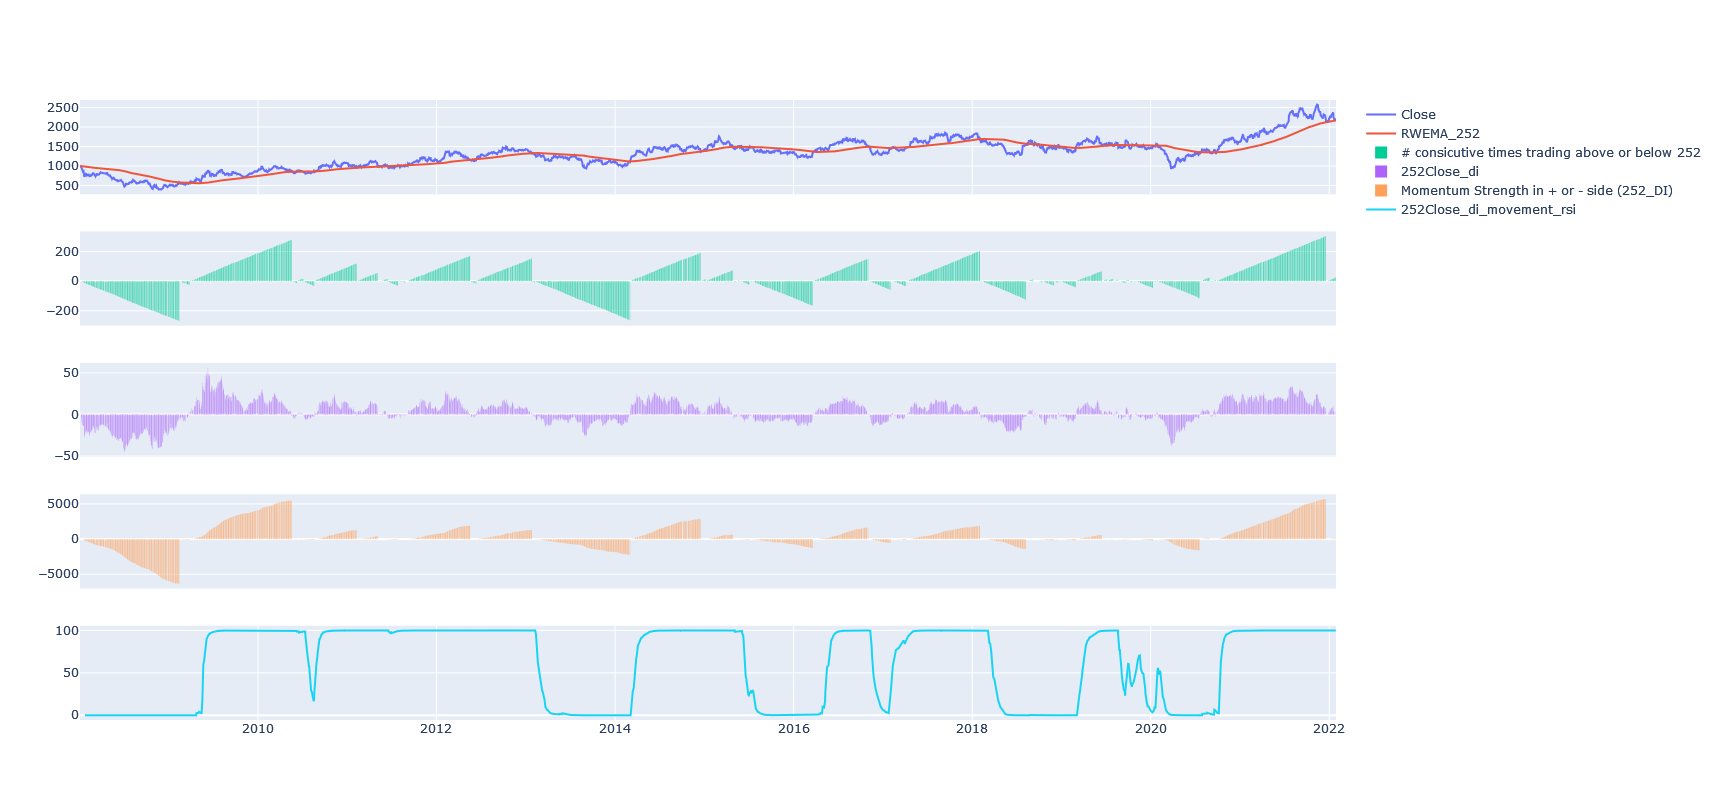

In [24]:
fig = make_subplots(rows=5, cols=1,shared_xaxes=True)
trace0 = go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close')
trace2 = go.Scatter(x=df.index,y=df['RWEMA_252'],mode='lines',name='RWEMA_252')
trace1 = go.Bar(x=df.index,y=df['RWEMA_252_movement'],name='# consicutive times trading above or below 252')
trace3 = go.Bar(x=df.index,y=df['252Close_di'],name='252Close_di')
trace4 = go.Bar(x=df.index,y=df['252Close_di_movement'],name='Momentum Strength in + or - side (252_DI)')
trace5 = go.Scatter(x=df.index,y=df['252Close_di_movement_rsi'],mode='lines',name='252Close_di_movement_rsi')
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace3, 3, 1)
fig.append_trace(trace4, 4, 1)
fig.append_trace(trace5, 5, 1)
fig.update_traces(dict(marker_line_width=0))
# fig = px.line(df[['Close','RWEMA_252','RWEMA_252_movement']],title="")
                
# fig.update_traces(marker_color='green')
fig.update_layout(autosize=False,width=1600,height=800,paper_bgcolor="white",)
fig.show()

In [25]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-04  1019.400024  1019.400024   994.000000   999.650024   758.357910   
2008-01-07  1000.000000  1010.000000   971.000000  1001.849976   760.026672   
2008-01-08  1001.000000  1007.599976   977.650024   985.299988   747.471558   
2008-01-09   971.250000   992.000000   960.000000   970.000000   735.864624   
2008-01-10   970.099976   979.700012   935.000000   938.849976   712.233398   
...                 ...          ...          ...          ...          ...   
2022-01-21  2240.000000  2255.899902  2196.000000  2215.750000  2215.750000   
2022-01-24  2210.000000  2219.649902  2148.350098  2167.449951  2167.449951   
2022-01-25  2160.100098  2192.600098  2120.050049  2179.949951  2179.949951   
2022-01-27  2156.000000  2179.000000  2127.649902  2167.699951  2167.699951   
2022-01-28  2179.899902  2238.550049  2173.850098  2215.949951  2215.949951   

             Volume    RWEMA_252  RWEMA_252_movement  252Close_di  \
Date                                                                
2008-01-04   878761  1000.786851                -1.0    -0.113593   
2008-01-07   405377  1000.581342                 1.0     0.126790   
2008-01-08  1179008  1000.317419                -1.0    -1.501267   
2008-01-09   922322   999.962750                -2.0    -2.996387   
2008-01-10   632935   999.453531                -3.0    -6.063669   
...             ...          ...                 ...          ...   
2022-01-21   238038  2163.966023                20.0     2.393013   
2022-01-24   467114  2165.052548                21.0     0.110732   
2022-01-25   262179  2166.188048                22.0     0.635305   
2022-01-27   298193  2167.247640                23.0     0.020870   
2022-01-28   272371  2168.707561                24.0     2.178366   

            252Close_di_movement  252Close_di_movement_rsi  
Date                                                        
2008-01-04             -0.113593                       NaN  
2008-01-07              0.126790                       NaN  
2008-01-08             -1.501267                       NaN  
2008-01-09             -4.497653                       NaN  
2008-01-10            -10.561322                       NaN  
...                          ...                       ...  
2022-01-21             95.606307                     100.0  
2022-01-24             95.717039                     100.0  
2022-01-25             96.352344                     100.0  
2022-01-27             96.373214                     100.0  
2022-01-28             98.551580                     100.0  

[3466 rows x 11 columns]

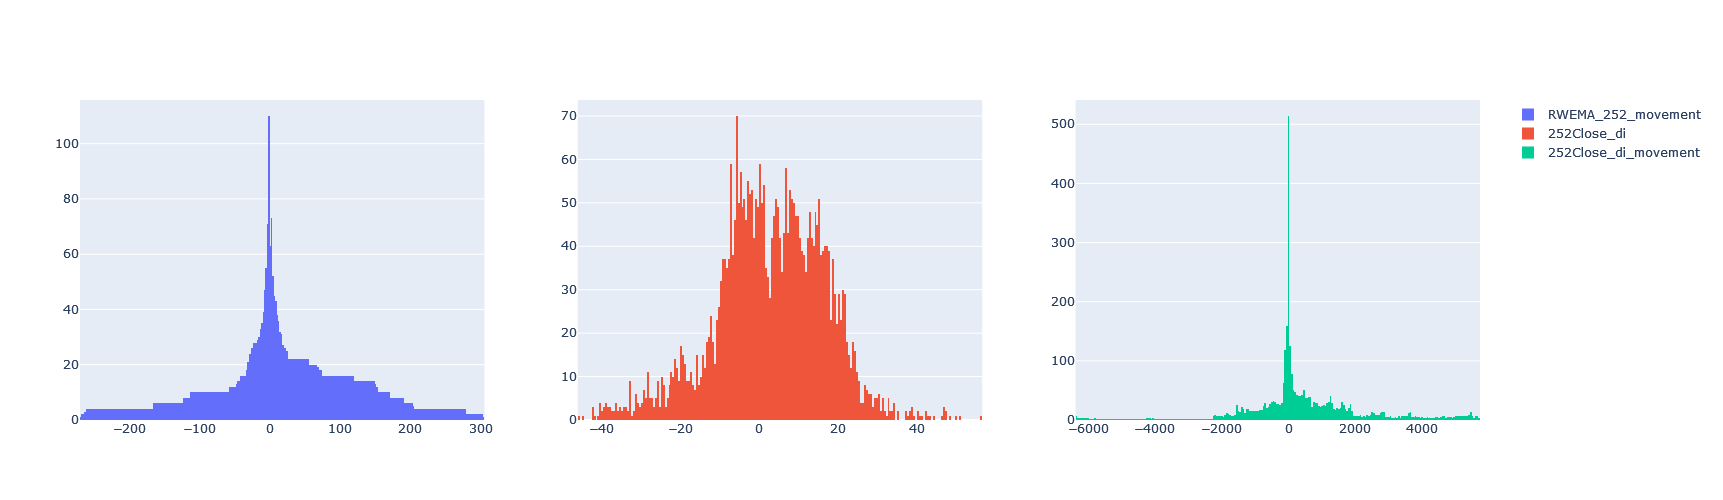

In [13]:
fig = make_subplots(rows=1, cols=3)

trace1 = go.Histogram(x=df['RWEMA_252_movement'],name='RWEMA_252_movement', nbinsx=500)
trace2 = go.Histogram(x=df['252Close_di'],name='252Close_di', nbinsx=500)
trace3 = go.Histogram(x=df['252Close_di_movement'],name='252Close_di_movement', nbinsx=500)



fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)

fig.update_layout(autosize=False,width=1700,height=500,paper_bgcolor="white",)

fig.show()

In [14]:
####Weekly Data
window=[10]     #10 for week , 50 Days
field='Close'
wdf=rwema(window,wdf,field)

In [38]:
# bins=[-1000,-500,-252,-125,-15,0,15,125,252,500,1000]
bins=[-42,-15,0,15,42]
groups=df.groupby(pd.cut(df['RWEMA_252_movement'],bins))
data=groups.Close.count()
data

RWEMA_252_movement
(-42, -15]    312
(-15, 0]      390
(0, 15]       382
(15, 42]      322
Name: Close, dtype: int64

<AxesSubplot:xlabel='RWEMA_252_movement'>

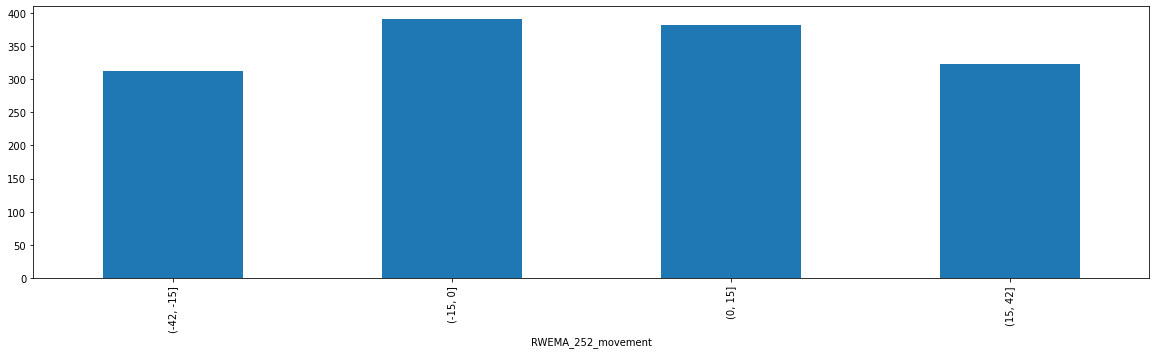

In [39]:
data.plot(kind='bar',figsize=(20, 5))

In [207]:
temp=[-500,-400,-300,-200,-100,-50,-30,-20,-15,-10,-5,-2,-1,0,1,2,5,10,15,20,30,50,100,200,300,400,500]
len(temp) #--13
range(len(temp)) #--(0,13)
temp.index(0) #-- Zero at 6th Index
neg={}
pos={}


for i in range(0,temp.index(0)):
    # print(i+1+temp.index(0),temp.index(0)-1-i)
    # print(f" Searching from {temp[temp.index(0)]} to {temp[temp.index(0)-1-i]}")
    tempcountneg=df['RWEMA_252_movement'].loc[(df['RWEMA_252_movement']>temp[temp.index(0)-1-i])&(df['RWEMA_252_movement']<temp[temp.index(0)])].count()
    neg[f"{temp[temp.index(0)]} - {temp[temp.index(0)-1-i]}"]=tempcountneg
    # neglist.append(tempcountneg*-1)
    
    # print(f" Searching from {temp[temp.index(0)]} to {temp[i+1+temp.index(0)]}")
    tempcountpos=df['RWEMA_252_movement'].loc[(df['RWEMA_252_movement']<temp[i+1+temp.index(0)])&(df['RWEMA_252_movement']>temp[temp.index(0)])].count()
    pos[f"{temp[temp.index(0)]} - {temp[i+1+temp.index(0)]}"]=tempcountpos
    # poslist.append(tempcountpos)
negdf=pd.DataFrame(neg,index=[0])
posdf=pd.DataFrame(pos,index=[0]) 
    
## .iloc[::-1] to reverse the Dataframe
# negdf=negdf.T.iloc[::-1]
negdf=negdf.T
posdf=posdf.T

#######Setting the coulmns
negdf.reset_index(inplace=True)
negdf.columns=['Range','Total']
negdf.set_index('Range',inplace=True)

posdf.reset_index(inplace=True)
posdf.columns=['Range','Total']
posdf.set_index('Range',inplace=True)

######Calculating total change between days
negdf['Diff']=abs(negdf['Total']-negdf['Total'].shift(1))
negdf.replace(to_replace=np.nan,value=0,inplace=True)
negdf['%Reach']=abs((negdf['Diff']/negdf['Total'][temp.index(0)-1])*100)
# print(negdf['Total'][temp.index(0)-1])


posdf['Diff']=abs(posdf['Total']-posdf['Total'].shift(1))
posdf.replace(to_replace=np.nan,value=0,inplace=True)
posdf['%Reach']=abs((posdf['Diff']/posdf['Total'][temp.index(0)-1])*100)
# print(posdf['Total'][temp.index(0)-1])

######Reversing the datatable
negdf=negdf.iloc[::-1]

newdf=negdf.append(posdf)

# df['RWEMA_252_movement'].loc[(df['RWEMA_252_movement']>-15)&(df['RWEMA_252_movement']<0)].count()

In [208]:
newdf

Total   Diff     %Reach
Range                            
0 - -500   1457    0.0   0.000000
0 - -400   1457    0.0   0.000000
0 - -300   1457  134.0   9.196980
0 - -200   1323  307.0  21.070693
0 - -100   1016  259.0  17.776253
0 - -50     757  162.0  11.118737
0 - -30     595  132.0   9.059712
0 - -20     463   73.0   5.010295
0 - -15     390   86.0   5.902539
0 - -10     304  123.0   8.442004
0 - -5      181  118.0   8.098833
0 - -2       63   63.0   4.323953
0 - -1        0    0.0   0.000000
0 - 1         0    0.0   0.000000
0 - 2        63   63.0   3.135889
0 - 5       164  101.0   5.027377
0 - 10      276  112.0   5.574913
0 - 15      366   90.0   4.479841
0 - 20      440   74.0   3.683425
0 - 30      561  121.0   6.022897
0 - 50      781  220.0  10.950722
0 - 100    1230  449.0  22.349428
0 - 200    1819  589.0  29.318069
0 - 300    2004  185.0   9.208561
0 - 400    2009    5.0   0.248880
0 - 500    2009    0.0   0.000000

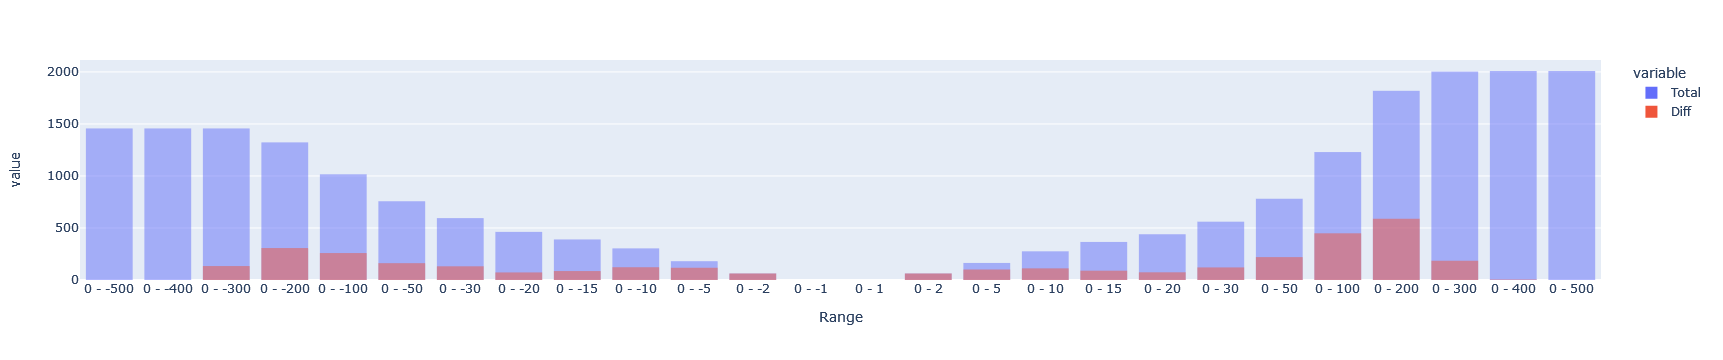

In [191]:
fig = px.bar(newdf[['Total','Diff']],title="",barmode='overlay') ##One of `'group'`, `'overlay'` or `'relative'
fig.update_traces(dict(marker_line_width=0))
# fig.update_traces(marker_color='green')
fig.show()

### What below graph reprersent
# We first calculated 252 Days REMA

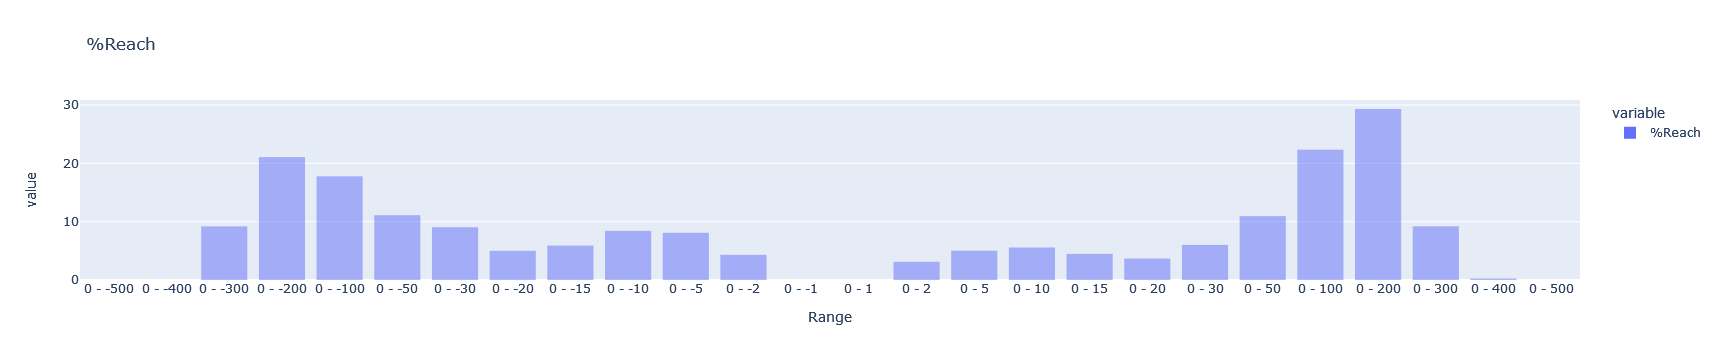

In [209]:
fig = px.bar(newdf[['%Reach']],title="%Reach",barmode='overlay') ##One of `'group'`, `'overlay'` or `'relative'
fig.update_traces(dict(marker_line_width=0))
# fig.update_traces(marker_color='green')
fig.show()

In [15]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-04  1019.400024  1019.400024   994.000000   999.650024   758.357910   
2008-01-07  1000.000000  1010.000000   971.000000  1001.849976   760.026672   
2008-01-08  1001.000000  1007.599976   977.650024   985.299988   747.471558   
2008-01-09   971.250000   992.000000   960.000000   970.000000   735.864624   
2008-01-10   970.099976   979.700012   935.000000   938.849976   712.233398   
...                 ...          ...          ...          ...          ...   
2022-01-21  2240.000000  2255.899902  2196.000000  2215.750000  2215.750000   
2022-01-24  2210.000000  2219.649902  2148.350098  2167.449951  2167.449951   
2022-01-25  2160.100098  2192.600098  2120.050049  2179.949951  2179.949951   
2022-01-27  2156.000000  2179.000000  2127.649902  2167.699951  2167.699951   
2022-01-28  2179.899902  2238.550049  2173.850098  2215.949951  2215.949951   

             Volume    RWEMA_252  RWEMA_252_movement  252Close_di  \
Date                                                                
2008-01-04   878761  1000.786851                -1.0    -0.113593   
2008-01-07   405377  1000.581342                 1.0     0.126790   
2008-01-08  1179008  1000.317419                -1.0    -1.501267   
2008-01-09   922322   999.962750                -2.0    -2.996387   
2008-01-10   632935   999.453531                -3.0    -6.063669   
...             ...          ...                 ...          ...   
2022-01-21   238038  2163.966023                20.0     2.393013   
2022-01-24   467114  2165.052548                21.0     0.110732   
2022-01-25   262179  2166.188048                22.0     0.635305   
2022-01-27   298193  2167.247640                23.0     0.020870   
2022-01-28   272371  2168.707561                24.0     2.178366   

            252Close_di_movement  252Close_di_movement_rsi  
Date                                                        
2008-01-04             -0.113593                       NaN  
2008-01-07              0.126790                       NaN  
2008-01-08             -1.501267                       NaN  
2008-01-09             -4.497653                       NaN  
2008-01-10            -10.561322                       NaN  
...                          ...                       ...  
2022-01-21             95.606307                 44.308110  
2022-01-24             95.717039                 39.678389  
2022-01-25             96.352344                 41.385355  
2022-01-27             96.373214                 40.185223  
2022-01-28             98.551580                 46.736930  

[3466 rows x 11 columns]

In [16]:
bins=[-25,-20,-15,-10,-5,-2,-1,0,1,2,5,10,15,20,25,]
groups=df.groupby(pd.cut(df['252Close_di'],bins))
data=groups.Close.count()
data

252Close_di
(-25, -20]     90
(-20, -15]    112
(-15, -10]    178
(-10, -5]     441
(-5, -2]      310
(-2, -1]       95
(-1, 0]       100
(0, 1]        109
(1, 2]         89
(2, 5]        250
(5, 10]       468
(10, 15]      418
(15, 20]      358
(20, 25]      201
Name: Close, dtype: int64

<AxesSubplot:xlabel='252Close_di'>

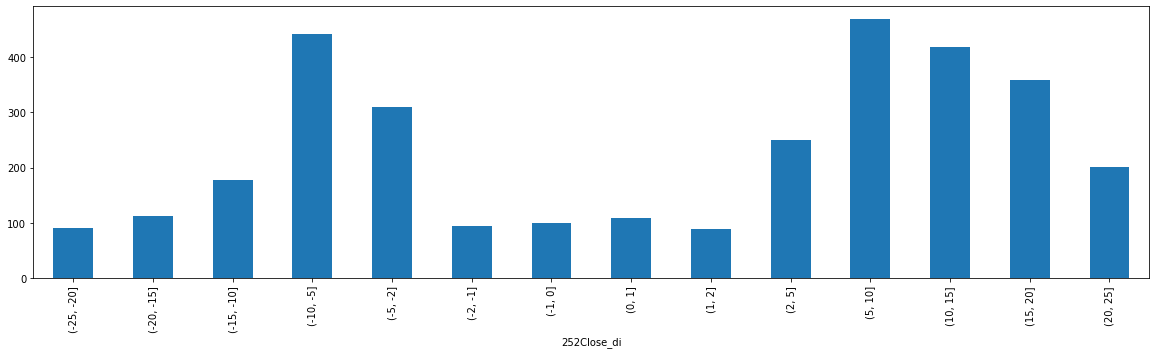

In [17]:
data.plot(kind='bar',figsize=(20, 5))

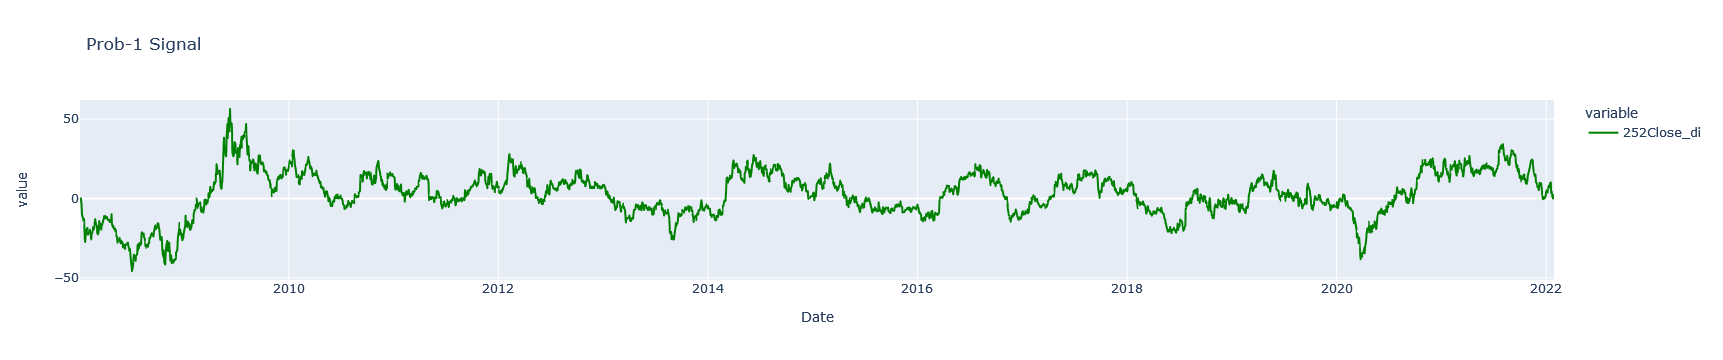

In [18]:
fig = px.line(df['252Close_di'],title="Prob-1 Signal",color_discrete_sequence =['green']*len(df))
# fig.update_traces(marker_color='green')
fig.show()


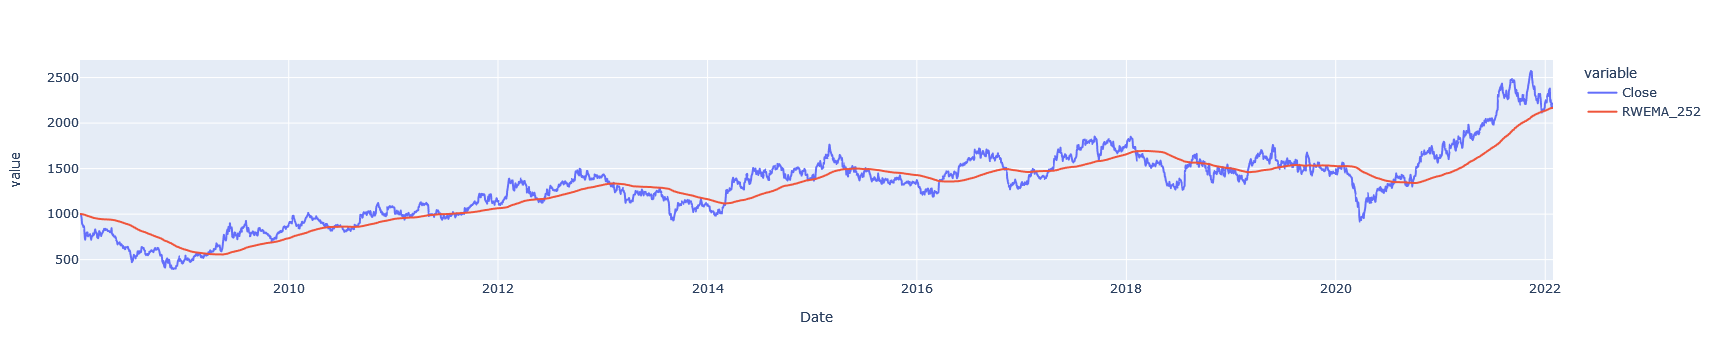

In [19]:
fig = px.line(df[['Close','RWEMA_252']],title="")
# fig.update_traces(marker_color='green')
fig.show()


In [20]:
bins=[-500,-60,-30,-20,-9,-8,-7,-6,-5,-4,-3,-2,0,2,3,4,5,6,7,8,9,20,30,60,500]
groups=df.groupby(pd.cut(df['252Close_di_movement'],bins))
data=groups.Close.count()
data

252Close_di_movement
(-500, -60]    403
(-60, -30]      93
(-30, -20]      56
(-20, -9]       64
(-9, -8]        10
(-8, -7]        11
(-7, -6]        11
(-6, -5]        11
(-5, -4]        19
(-4, -3]        21
(-3, -2]        26
(-2, 0]         62
(0, 2]          77
(2, 3]          25
(3, 4]          13
(4, 5]          16
(5, 6]          13
(6, 7]           9
(7, 8]           9
(8, 9]           4
(9, 20]         65
(20, 30]        41
(30, 60]        82
(60, 500]      436
Name: Close, dtype: int64

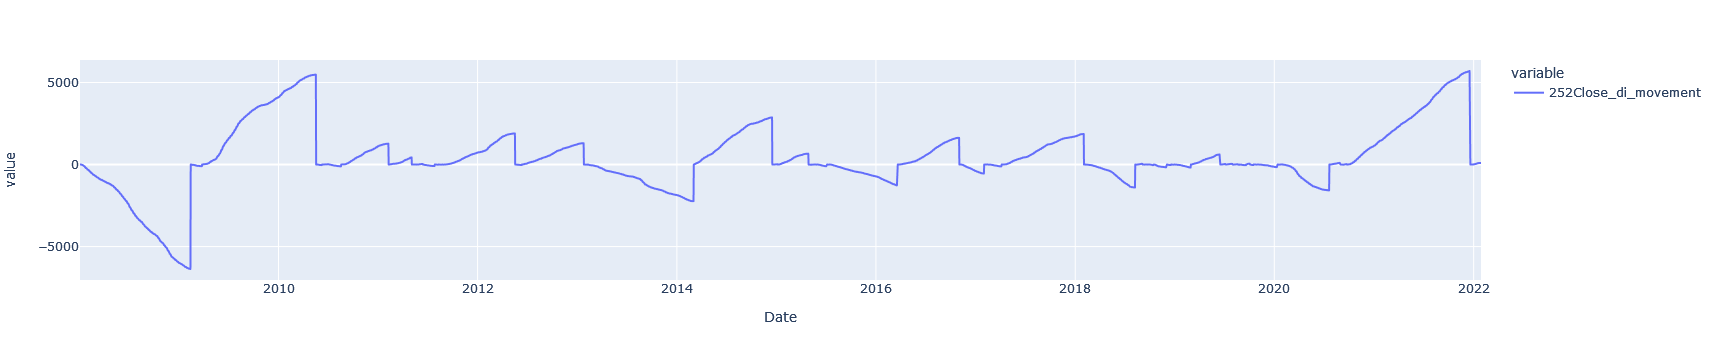

In [21]:
fig = px.line(df['252Close_di_movement'])
# fig.update_traces(marker_color='green')
fig.show()

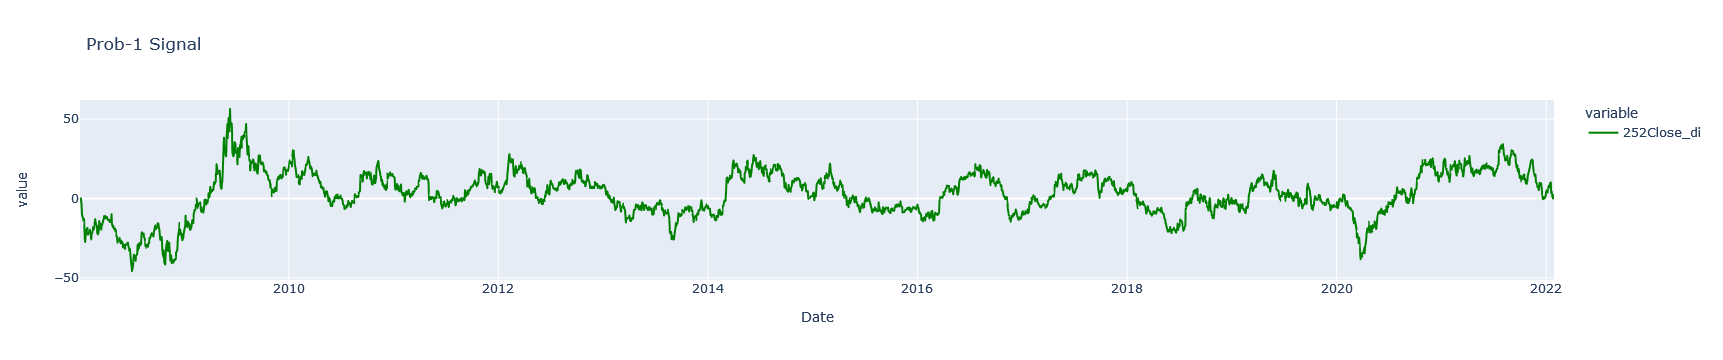

In [22]:
fig = px.line(df['252Close_di'],title="Prob-1 Signal",color_discrete_sequence =['green']*len(df))
# fig.update_traces(marker_color='green')
fig.show()
